In [2]:
# Freight-RevIQ | Revenue Leakage Detection Engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [3]:
# Load shipment and billing data
shipments = pd.read_csv("../data/shipments.csv")
billing   = pd.read_csv("../data/billing.csv")

# Merge both datasets on shipment_id
df = pd.merge(shipments, billing, on="shipment_id", how="inner")

# Quick look at merged data
df.head()

,shipment_id,ship_date,origin_zip,dest_zip,freight_class,weight_lbs,distance_miles,liftgate_required,residential_delivery,fuel_surcharge_rate,base_linehaul_charge,billed_fuel_surcharge,billed_liftgate_fee,billed_residential_fee,total_billed_amount
0,SHP-1001,2025-10-01,38125,77001,55.00,1200,480,True,False,0.12,680,60,75,0,815
1,SHP-1002,2025-10-01,38125,90001,70.00,800,1800,False,True,0.15,2100,0,0,95,2195
2,SHP-1003,2025-10-02,75001,30301,92.50,450,820,False,False,0.11,950,105,0,0,1055
3,SHP-1004,2025-10-03,60601,10001,70.00,1500,790,True,True,0.13,1425,185,0,0,1610
4,SHP-1005,2025-10-03,38125,38109,55.00,300,18,False,False,0.08,120,12,0,0,132


In [4]:
# 1. Helper: base rate per mile per pound by freight class
# (In real LTL pricing this comes from a giant tariff table.
# We're modeling a simplified version to simulate that logic.)

def estimate_linehaul_rate_per_lb_mile(freight_class):
    """
    Lower freight class (like 55) = cheaper per lb.
    Higher class (like 92.5) = more expensive.
    We'll make a simple stepped rate model.
    """
    if freight_class <= 60:
        return 0.012  # $/lb/mile
    elif freight_class <= 75:
        return 0.015
    elif freight_class <= 85:
        return 0.017
    else:
        return 0.020  # more expensive freight to handle

# 2. Calculate expected base linehaul charge
df["expected_linehaul_charge"] = (
    df.apply(
        lambda row: row["weight_lbs"]
        * row["distance_miles"]
        * estimate_linehaul_rate_per_lb_mile(row["freight_class"]),
        axis=1
    ).round(2)
)

# 3. Expected fuel surcharge = linehaul * fuel_surcharge_rate
df["expected_fuel_surcharge"] = (
    df["expected_linehaul_charge"] * df["fuel_surcharge_rate"]
).round(2)

# 4. Accessorial fees (liftgate, residential)
# We'll assume:
# - liftgate fee: $75 flat
# - residential delivery fee: $95 flat
df["expected_liftgate_fee"] = np.where(df["liftgate_required"] == True, 75.00, 0.00)
df["expected_residential_fee"] = np.where(df["residential_delivery"] == True, 95.00, 0.00)

# 5. Expected total charge
df["expected_total_charge"] = (
    df["expected_linehaul_charge"]
    + df["expected_fuel_surcharge"]
    + df["expected_liftgate_fee"]
    + df["expected_residential_fee"]
).round(2)

# 6. Bring over the actual billed total for comparison
df["actual_total_billed"] = df["total_billed_amount"].round(2)

df[[
    "shipment_id",
    "expected_linehaul_charge",
    "expected_fuel_surcharge",
    "expected_liftgate_fee",
    "expected_residential_fee",
    "expected_total_charge",
    "actual_total_billed"
]]

#What this cell is doing (so you can explain it):
#We create a pricing model that simulates what FedEx Freight “should” have charged for each shipment.
#We build that from distance, weight, class, surcharges, and accessorial fees.
#Then we compare that to the real invoice.
#This is literally revenue assurance.

,shipment_id,expected_linehaul_charge,expected_fuel_surcharge,expected_liftgate_fee,expected_residential_fee,expected_total_charge,actual_total_billed
0,SHP-1001,"6,912.00",829.44,75.00,0.00,"7,816.44",815
1,SHP-1002,"21,600.00","3,240.00",0.00,95.00,"24,935.00",2195
2,SHP-1003,"7,380.00",811.80,0.00,0.00,"8,191.80",1055
3,SHP-1004,"17,775.00","2,310.75",75.00,95.00,"20,255.75",1610
4,SHP-1005,64.80,5.18,0.00,0.00,69.98,132


In [5]:
#Flag Revenue Leakage
# Calculate leakage $ and leakage %
df["leakage_amount"] = (df["expected_total_charge"] - df["actual_total_billed"]).round(2)
df["leakage_pct"] = np.where(
    df["expected_total_charge"] > 0,
    (df["leakage_amount"] / df["expected_total_charge"] * 100).round(2),
    0
)

# Rule-based reasons for leakage
reasons = []

for _, row in df.iterrows():
    row_reasons = []

    # underbilled overall
    if row["leakage_amount"] > 0 and row["leakage_pct"] >= 5:
        row_reasons.append(f"Underbilled by {row['leakage_pct']}%")

    # missing fuel surcharge for long haul
    if (
        row["distance_miles"] > 500
        and row["expected_fuel_surcharge"] > 0
        and row["billed_fuel_surcharge"] == 0
    ):
        row_reasons.append("Fuel surcharge not billed")

    # liftgate required but not billed
    if (
        row["liftgate_required"] == True
        and row["expected_liftgate_fee"] > 0
        and row["billed_liftgate_fee"] == 0
    ):
        row_reasons.append("Liftgate fee missing")

    # residential delivery but not billed
    if (
        row["residential_delivery"] == True
        and row["expected_residential_fee"] > 0
        and row["billed_residential_fee"] == 0
    ):
        row_reasons.append("Residential fee missing")

    reasons.append("; ".join(row_reasons) if row_reasons else "")

df["leakage_reason"] = reasons

# Show only shipments where there's an issue
leakage_df = df[df["leakage_reason"] != ""].copy()

leakage_df[[
    "shipment_id",
    "expected_total_charge",
    "actual_total_billed",
    "leakage_amount",
    "leakage_pct",
    "leakage_reason"
]]

,shipment_id,expected_total_charge,actual_total_billed,leakage_amount,leakage_pct,leakage_reason
0,SHP-1001,"7,816.44",815,"7,001.44",89.57,Underbilled by 89.57%
1,SHP-1002,"24,935.00",2195,"22,740.00",91.20,Underbilled by 91.2%; Fuel surcharge not billed
2,SHP-1003,"8,191.80",1055,"7,136.80",87.12,Underbilled by 87.12%
3,SHP-1004,"20,255.75",1610,"18,645.75",92.05,Underbilled by 92.05%; Liftgate fee missing; R...


In [6]:
#Export audit report + produce KPI chart
# Save the detailed leakage report to /reports
report_cols = [
    "shipment_id",
    "ship_date",
    "origin_zip",
    "dest_zip",
    "distance_miles",
    "weight_lbs",
    "expected_total_charge",
    "actual_total_billed",
    "leakage_amount",
    "leakage_pct",
    "leakage_reason"
]

leakage_report = leakage_df[report_cols].sort_values(
    by="leakage_amount", ascending=False
)

# Create reports folder if not exists, then save
import os
os.makedirs("../reports", exist_ok=True)

output_path = "../reports/leakage_report.csv"
leakage_report.to_csv(output_path, index=False)
output_path

'../reports/leakage_report.csv'

Total Recoverable Revenue ($) by Destination Zip:


dest_zip
90001   22,740.00
10001   18,645.75
30301    7,136.80
77001    7,001.44
Name: leakage_amount, dtype: float64

'../reports/leakage_by_dest.png'

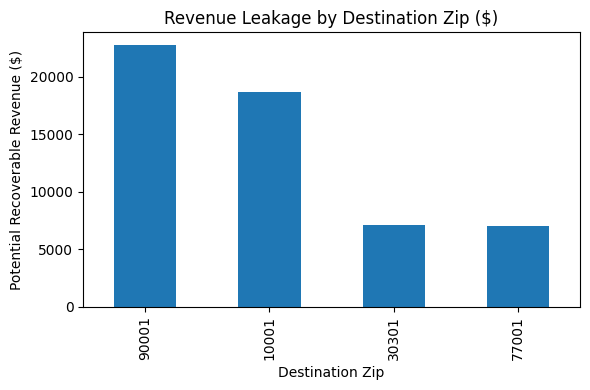

In [7]:
# KPI: total leakage $ by destination zip (top problem lanes / customers proxy)
leakage_by_dest = (
    leakage_df.groupby("dest_zip")["leakage_amount"]
    .sum()
    .sort_values(ascending=False)
)

print("Total Recoverable Revenue ($) by Destination Zip:")
display(leakage_by_dest)

# Bar chart for README screenshot
plt.figure(figsize=(6,4))
leakage_by_dest.plot(kind="bar")
plt.title("Revenue Leakage by Destination Zip ($)")
plt.ylabel("Potential Recoverable Revenue ($)")
plt.xlabel("Destination Zip")
plt.tight_layout()

chart_path = "../reports/leakage_by_dest.png"
plt.savefig(chart_path, dpi=300)
chart_path